<a href="https://colab.research.google.com/github/chabojosue/ml_term_project.ipynb/blob/main/ml_term_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term Project: Implementing ML Models from Scratch
## Machine Learning / Pattern Recognition
### FINAL INTERNATIONAL UNIVERSITY | Fall 2025-26

**Student Name: josue M'BEKALO CHABO **  
**Student ID:2203070021**  
**Due Date:** 27 December 2025 (Saturday) before midnight

---

## Overview

In this project, you will implement three fundamental machine learning models **from scratch**:
1. **Linear Regression** using gradient descent
2. **Logistic Regression** using gradient descent (binary classification)
3. **Decision Tree** using information gain (multi-class classification)

You will use the **Iris dataset** for all three tasks:
- **Linear Regression**: Predict `petal_width` from other features
- **Logistic Regression**: Classify `setosa` vs `non-setosa` (binary)
- **Decision Tree**: Classify all three species (multi-class)

**Important Rules:**
- ✅ **Allowed**: `sklearn` for dataset loading, `KFold`, and evaluation metrics
- ❌ **Not Allowed**: `sklearn` models (e.g., `LinearRegression`, `LogisticRegression`, `DecisionTreeClassifier`)
- ❌ **Not Allowed**: `GridSearchCV` or similar libraries for hyperparameter search
- All models must be implemented using **native Python and NumPy only**

**Grading:**
- Linear Regression Implementation: **20 pts**
- Linear Regression 5-Fold CV & Results: **10 pts**
- Logistic Regression Implementation: **20 pts**
- Logistic Regression 5-Fold CV & Results: **10 pts**
- Decision Tree Implementation: **20 pts**
- Decision Tree 5-Fold CV & Results: **10 pts**
- Written Questions (3 × 4 pts): **12 pts**
- **Total: 100 + 2 pts**

**Integrity Test:**
- **Date**: 3 January 2026 during lecture hours
- **Format**: Short quiz on paper
- **Pass (≥80%)**: Marks awarded directly from PDF
- **Fail (<80%)**: Demo session required
- **No Show**: 50% penalty

---

## Pre-Submission Checklist

- [ ] Name and student ID at top
- [ ] No cells are added or removed
- [ ] All TODO sections completed
- [ ] All questions answered
- [ ] Code runs without errors
- [ ] Results tables included with mean, std, and 95% CI
- [ ] Hyperparameter tuning plots included
- [ ] Run All before saving

## Setup and Imports

In [2]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Sklearn - ONLY for dataset, splitting, and metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load and Prepare Dataset

In [4]:
# Load Iris dataset
iris = load_iris()
X_full = iris.data  # Features: sepal_length, sepal_width, petal_length, petal_width
y_full = iris.target  # Labels: 0=setosa, 1=versicolor, 2=virginica

print("Dataset Information:")
print(f"  Total samples: {X_full.shape[0]}")
print(f"  Features: {iris.feature_names}")
print(f"  Classes: {iris.target_names}")
print(f"\nClass distribution: {dict(zip(iris.target_names, np.bincount(y_full)))}")

Dataset Information:
  Total samples: 150
  Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  Classes: ['setosa' 'versicolor' 'virginica']

Class distribution: {np.str_('setosa'): np.int64(50), np.str_('versicolor'): np.int64(50), np.str_('virginica'): np.int64(50)}


## Helper Functions

In [6]:
def compute_confidence_interval(values, confidence=0.95):
    """
    Compute mean, std, and 95% confidence interval.

    Args:
        values: List or array of values from k folds
        confidence: Confidence level (default 0.95)

    Returns:
        mean, std, (lower_bound, upper_bound)
    """
    values = np.array(values)
    n = len(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # Sample std

    # t-value for 95% CI with n-1 degrees of freedom (approx 2.776 for n=5)
    t_value = 2.776  # For 5 folds, df=4
    margin = t_value * (std / np.sqrt(n))

    return mean, std, (mean - margin, mean + margin)


def print_results(metric_name, values):
    """Print results with mean, std, and 95% CI."""
    mean, std, ci = compute_confidence_interval(values)
    print(f"{metric_name}: {mean:.4f} ± {std:.4f} (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")

---

# Task 1: Linear Regression (30 points)

Implement Linear Regression using gradient descent to predict `petal_width` from the other three features (`sepal_length`, `sepal_width`, `petal_length`).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 1.1: Implement LinearRegression Class (20 points)

In [8]:
class LinearRegression:
    """
    Linear Regression using gradient descent.

    Attributes:
        learning_rate: Step size for gradient descent
        n_iterations: Number of training iterations (fixed = 500)
        reg_strength: L2 regularisation strength (0 = no regularisation)
        weights: Model weights (including bias)
        train_losses: List of training losses per iteration
        val_losses: List of validation losses per iteration
    """

    def __init__(self, n_iterations=500, learning_rate=0.01, reg_strength=0.0):
        """
        Initialise the Linear Regression model.

        Args:
            learning_rate: Step size for gradient descent
            n_iterations: Number of training iterations
            reg_strength: L2 regularisation strength
        """
        # TODO: Store hyperparameters and initialise attributes (3 points)
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.reg_strength = reg_strength
        self.weights = None
        self.train_losses = []
        self.val_losses = []

    def _add_bias(self, X):
        """Add a column of ones for the bias term."""
        # TODO: Add bias column to X (2 points)
        # Hint: Use np.c_ or np.column_stack
        return np.c_[np.ones(X.shape[0]), X]

    def _compute_loss(self, X, y):
        """
        Compute Mean Squared Error loss with optional L2 regularisation.

        Loss = (1/2n) * sum((y_pred - y)^2) + (reg_strength/2) * sum(weights^2)

        Note: Do not regularise the bias term.
        """
        # TODO: Implement MSE loss with L2 regularisation (2 points)
        n = len(y)
        y_pred = X @ self.weights
        mse = (1 / (2 * n)) * np.sum((y_pred - y) ** 2)

        # L2 regularisation (exclude bias term at index 0)
        reg_term = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)

        return mse + reg_term

    def _compute_gradient(self, X, y):
        """
        Compute gradient of the loss function.

        Gradient = (1/n) * X.T @ (X @ weights - y) + reg_strength * weights

        Note: Do not regularise the bias term.
        """
        # TODO: Implement gradient computation (2 points)
        n = len(y)
        y_pred = X @ self.weights
        gradient = (1 / n) * (X.T @ (y_pred - y))

        # Add L2 regularisation term (exclude bias)
        reg_gradient = np.zeros_like(self.weights)
        reg_gradient[1:] = self.reg_strength * self.weights[1:]

        return gradient + reg_gradient

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using gradient descent.

        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional, for tracking val loss)
            y_val: Validation targets (optional)

        Returns:
            self
        """
        # TODO: Implement training loop (8 points)
        # Steps:
        # 1. Add bias to X_train (and X_val if provided)
        # 2. Initialise weights to zeros
        # 3. For each iteration:
        #    a. Compute gradient
        #    b. Update weights
        #    c. Record train loss
        #    d. Record val loss if X_val provided
        X_train_bias = self._add_bias(X_train)
        if X_val is not None:
            X_val_bias = self._add_bias(X_val)

        # 2. Initialise weights to zeros
        n_features = X_train_bias.shape[1]
        self.weights = np.zeros(n_features)

        # Reset loss history
        self.train_losses = []
        self.val_losses = []

        # 3. For each iteration:
        for i in range(self.n_iterations):
            # a. Compute gradient
            gradient = self._compute_gradient(X_train_bias, y_train)

            # b. Update weights
            self.weights -= self.learning_rate * gradient

            # c. Record train loss
            train_loss = self._compute_loss(X_train_bias, y_train)
            self.train_losses.append(train_loss)

            # d. Record val loss if X_val provided
            if X_val is not None:
                val_loss = self._compute_loss(X_val_bias, y_val)
                self.val_losses.append(val_loss)

        return self

    def predict(self, X):
        """
        Make predictions.

        Args:
            X: Features

        Returns:
            Predictions
        """
        # TODO: Add bias and compute predictions (3 points)
        X_bias = self._add_bias(X)
        return X_bias @ self.weights

## 1.2: 5-Fold Cross-Validation for Linear Regression (10 points)

**Steps:**
1. Prepare data: Use features [0, 1, 2] to predict feature [3] (petal_width)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [9]:
# Prepare data for Linear Regression
# Features: sepal_length, sepal_width, petal_length
# Target: petal_width
X_linreg = X_full[:, :3]  # First 3 features
y_linreg = X_full[:, 3]   # 4th feature as target

# Standardise features
scaler = StandardScaler()
X_linreg = scaler.fit_transform(X_linreg)

print(f"Linear Regression Data:")
print(f"  X shape: {X_linreg.shape}")
print(f"  y shape: {y_linreg.shape}")

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

# Storage for results
mse_scores = []
r2_scores = []
best_params_per_fold = []

# For plotting (save from one fold)
plot_train_losses = None
plot_val_losses = None
plot_fold = 1

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("LINEAR REGRESSION: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_linreg), 1):
    print(f"\n--- Fold {fold_num} ---")

    # Split data
    X_train_full, X_test = X_linreg[train_idx], X_linreg[test_idx]
    y_train_full, y_test = y_linreg[train_idx], y_linreg[test_idx]

    # TODO: Further split train into train_inner and validation (80%-20%) (1 points)
    # Hint: Use simple index slicing or another KFold split
    n_train = len(X_train_full)
    split_idx = int(0.8 * n_train)
    X_train_inner = X_train_full[:split_idx]
    y_train_inner = y_train_full[:split_idx]
    X_val = X_train_full[split_idx:]
    y_val = y_train_full[split_idx:]
    # TODO: Grid search over hyperparameters (3 points)
    # For each combination of (learning_rate, reg_strength):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set
    #   3. Track best parameters based on validation MSE
    best_val_mse = float('inf')
    best_lr = None
    best_reg = None
    best_model = None

    print(f"  Grid search on {len(learning_rates) * len(reg_strengths)} combinations...")

    for lr in learning_rates:
        for reg in reg_strengths:
            # Train on inner training set
            model = LinearRegression(
                n_iterations=500,
                learning_rate=lr,
                reg_strength=reg
            )
            model.fit(X_train_inner, y_train_inner, X_val, y_val)

            # Evaluate on validation set
            y_val_pred = model.predict(X_val)
            val_mse = mean_squared_error(y_val, y_val_pred)

            # Track best parameters
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_lr = lr
                best_reg = reg
                best_model = model

    print(f"  Best params: lr={best_lr}, reg={best_reg}, val_mse={best_val_mse:.6f}")
    best_params_per_fold.append({'lr': best_lr, 'reg': best_reg})
    # TODO: Save train/val losses from one hyperparameter setting for plotting (1 points)
    # (Pick fold 1 and the middle hyperparameter values)
    if fold_num == plot_fold:
        # Use middle hyperparameter values for plotting
        plot_lr = learning_rates[len(learning_rates)//2]
        plot_reg = reg_strengths[len(reg_strengths)//2]

        plot_model = LinearRegression(
            n_iterations=500,
            learning_rate=plot_lr,
            reg_strength=plot_reg
        )
        plot_model.fit(X_train_inner, y_train_inner, X_val, y_val)

        plot_train_losses = plot_model.train_losses
        plot_val_losses = plot_model.val_losses
        print(f"  Saved loss curves (lr={plot_lr}, reg={plot_reg}) for plotting")
    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = LinearRegression(
        n_iterations=500,
        learning_rate=best_lr,
        reg_strength=best_reg
    )
    final_model.fit(X_train_full, y_train_full)
    # TODO: Evaluate on test set and store results (1 points)
    y_test_pred = final_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    mse_scores.append(test_mse)
    r2_scores.append(test_r2)

    print(f"  Test MSE: {test_mse:.6f}, Test R²: {test_r2:.6f}")
    pass

# TODO: Print final results with mean, std, and 95% CI (1 points)
print("\n" + "="*60)
print("LINEAR REGRESSION: FINAL RESULTS")
print("="*60)
print_results("Test MSE", mse_scores)
print_results("Test R²", r2_scores)

print("\nBest parameters per fold:")
for i, params in enumerate(best_params_per_fold, 1):
    print(f"  Fold {i}: lr={params['lr']}, reg={params['reg']}")


Linear Regression Data:
  X shape: (150, 3)
  y shape: (150,)

LINEAR REGRESSION: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
  Grid search on 6 combinations...
  Best params: lr=0.1, reg=0.01, val_mse=0.086185
  Saved loss curves (lr=0.01, reg=0.1) for plotting
  Test MSE: 0.044931, Test R²: 0.929315

--- Fold 2 ---
  Grid search on 6 combinations...
  Best params: lr=0.1, reg=0.01, val_mse=0.108730
  Test MSE: 0.024811, Test R²: 0.953450

--- Fold 3 ---
  Grid search on 6 combinations...
  Best params: lr=0.1, reg=0.01, val_mse=0.106073
  Test MSE: 0.035715, Test R²: 0.936820

--- Fold 4 ---
  Grid search on 6 combinations...
  Best params: lr=0.1, reg=0.01, val_mse=0.096966
  Test MSE: 0.045842, Test R²: 0.922752

--- Fold 5 ---
  Grid search on 6 combinations...
  Best params: lr=0.1, reg=0.01, val_mse=0.089117
  Test MSE: 0.041847, Test R²: 0.912079

LINEAR REGRESSION: FINAL RESULTS
Test MSE: 0.0386 ± 0.0087 (95% CI: [0.0279, 0.0494])
Test R²: 0.9309 ± 0.0155 (95% CI: [0.9116, 0.9502]

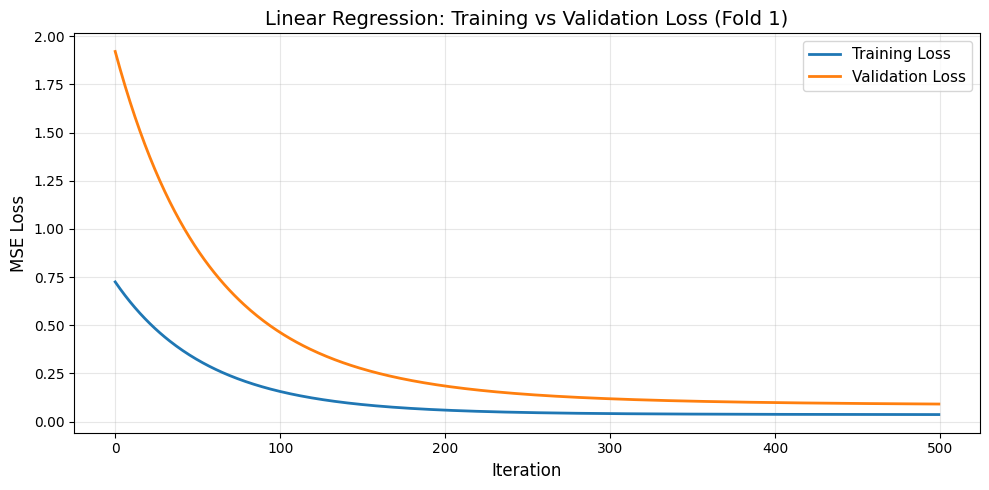

In [10]:
# TODO: Plot training and validation loss curves (1 points)
# Use plot_train_losses and plot_val_losses saved from fold 1

plt.figure(figsize=(10, 5))
# TODO: Create the plot (1 points)
# plt.plot(...)
# plt.xlabel('Iteration')
# plt.ylabel('MSE Loss')
# plt.title('Linear Regression: Training vs Validation Loss')
# plt.legend()
# plt.grid(True)
plt.plot(plot_train_losses, label='Training Loss', linewidth=2)
plt.plot(plot_val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title(f'Linear Regression: Training vs Validation Loss (Fold {plot_fold})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Question 1:** Explain how L2 regularisation affects the weights during training. (4 points, 4-5 sentences)

**[YOUR ANSWER HERE]**

---

# Task 2: Logistic Regression (30 points)

Implement Logistic Regression using gradient descent for binary classification. You will classify `setosa` (class 0) vs `non-setosa` (classes 1 and 2).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 2.1: Implement LogisticRegression Class (20 points)

In [11]:
class LogisticRegression:
    """
    Logistic Regression using gradient descent for binary classification.

    Attributes:
        learning_rate: Step size for gradient descent
        n_iterations: Number of training iterations (fixed 500)
        reg_strength: L2 regularisation strength
        weights: Model weights (including bias)
        train_losses: List of training losses per iteration
        val_losses: List of validation losses per iteration
    """

    def __init__(self, learning_rate=0.01, n_iterations=500, reg_strength=0.0):
        """
        Initialise the Logistic Regression model.

        Args:
            learning_rate: Step size for gradient descent
            n_iterations: Number of training iterations
            reg_strength: L2 regularisation strength
        """
        # TODO: Store hyperparameters and initialise attributes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.reg_strength = reg_strength
        self.weights = None
        self.train_losses = []
        self.val_losses = []

    def _add_bias(self, X):
        """Add a column of ones for the bias term."""
        # TODO: Add bias column to X (2 points)
        return np.c_[np.ones(X.shape[0]), X]

    def _sigmoid(self, z):
        """
        Compute sigmoid function.

        sigmoid(z) = 1 / (1 + exp(-z))

        Hint: Clip z to avoid overflow (e.g., np.clip(z, -500, 500))
        """
        # TODO: Implement sigmoid (2 points)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """
        Compute binary cross-entropy loss with optional L2 regularisation.

        Loss = -(1/n) * sum(y*log(p) + (1-y)*log(1-p)) + (reg_strength/2) * sum(weights^2)

        Hint: Use np.clip on probabilities to avoid log(0)
        Note: Do not regularise the bias term.
        """
        # TODO: Implement cross-entropy loss with L2 regularisation (2 points)
        n = len(y)
        z = X @ self.weights
        p = self._sigmoid(z)

        # Clip probabilities to avoid log(0)
        epsilon = 1e-15
        p = np.clip(p, epsilon, 1 - epsilon)

        # Binary cross-entropy
        cross_entropy = -(1 / n) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

        # L2 regularisation (exclude bias term at index 0)
        reg_term = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)

        return cross_entropy + reg_term

    def _compute_gradient(self, X, y):
        """
        Compute gradient of the loss function.

        Gradient = (1/n) * X.T @ (sigmoid(X @ weights) - y) + reg_strength * weights

        Note: Do not regularise the bias term.
        """
        # TODO: Implement gradient computation (2 points)
        n = len(y)
        z = X @ self.weights
        p = self._sigmoid(z)

        # Gradient
        gradient = (1 / n) * (X.T @ (p - y))

        # Add L2 regularisation term (exclude bias)
        reg_gradient = np.zeros_like(self.weights)
        reg_gradient[1:] = self.reg_strength * self.weights[1:]

        return gradient + reg_gradient

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using gradient descent.

        Args:
            X_train: Training features
            y_train: Training labels (0 or 1)
            X_val: Validation features (optional)
            y_val: Validation labels (optional)

        Returns:
            self
        """
        # TODO: Implement training loop (8 points)
        # Steps:
        # 1. Add bias to X_train (and X_val if provided)
        # 2. Initialise weights to zeros
        # 3. For each iteration:
        #    a. Compute gradient
        #    b. Update weights
        #    c. Record train loss
        #    d. Record val loss if X_val provided
        # 1. Add bias to X_train (and X_val if provided)
        X_train_bias = self._add_bias(X_train)
        if X_val is not None:
            X_val_bias = self._add_bias(X_val)

        # 2. Initialise weights to zeros
        n_features = X_train_bias.shape[1]
        self.weights = np.zeros(n_features)

        # Reset loss history
        self.train_losses = []
        self.val_losses = []

        # 3. For each iteration:
        for i in range(self.n_iterations):
            # a. Compute gradient
            gradient = self._compute_gradient(X_train_bias, y_train)

            # b. Update weights
            self.weights -= self.learning_rate * gradient

            # c. Record train loss
            train_loss = self._compute_loss(X_train_bias, y_train)
            self.train_losses.append(train_loss)

            # d. Record val loss if X_val provided
            if X_val is not None:
                val_loss = self._compute_loss(X_val_bias, y_val)
                self.val_losses.append(val_loss)

        return self

    def predict_proba(self, X):
        """
        Predict probabilities.

        Args:
            X: Features

        Returns:
            Probabilities of class 1
        """
        # TODO: Add bias and compute probabilities using sigmoid (2 points)
        X_bias = self._add_bias(X)
        z = X_bias @ self.weights
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """
        Make class predictions.

        Args:
            X: Features
            threshold: Classification threshold (default 0.5)

        Returns:
            Class predictions (0 or 1)
        """
        # TODO: Get probabilities and apply threshold (2 points)
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

## 2.2: 5-Fold Cross-Validation for Logistic Regression (10 points)

**Steps:**
1. Prepare data: Binary labels (setosa=1, non-setosa=0)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [12]:
# Prepare data for Logistic Regression
# Binary classification: setosa (0) vs non-setosa (1, 2)
X_logreg = X_full.copy()
y_logreg = (y_full == 0).astype(int)  # 1 for setosa, 0 for others

# Standardise features
scaler = StandardScaler()
X_logreg = scaler.fit_transform(X_logreg)

print(f"Logistic Regression Data:")
print(f"  X shape: {X_logreg.shape}")
print(f"  y shape: {y_logreg.shape}")
print(f"  Class distribution: {dict(Counter(y_logreg))}")

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting (save from one fold)
plot_train_losses = None
plot_val_losses = None

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_logreg), 1):
    print(f"\n--- Fold {fold_num} ---")

    # Split data
    X_train_full, X_test = X_logreg[train_idx], X_logreg[test_idx]
    y_train_full, y_test = y_logreg[train_idx], y_logreg[test_idx]

    # TODO: Further split train into train_inner and validation (80%-20%)
    n_train = len(X_train_full)
    split_idx = int(0.8 * n_train)
    X_train_inner = X_train_full[:split_idx]
    y_train_inner = y_train_full[:split_idx]
    X_val = X_train_full[split_idx:]
    y_val = y_train_full[split_idx:]
    # TODO: Grid search over hyperparameters (3 points)
    # For each combination of (learning_rate, reg_strength):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set (use accuracy for selection)
    #   3. Track best parameters
    best_val_acc = 0
    best_lr = None
    best_reg = None
    best_model = None

    print(f"  Grid search on {len(learning_rates) * len(reg_strengths)} combinations...")

    for lr in learning_rates:
        for reg in reg_strengths:
            # Train on inner training set
            model = LogisticRegression(
                learning_rate=lr,
                n_iterations=500,
                reg_strength=reg
            )
            model.fit(X_train_inner, y_train_inner, X_val, y_val)

            # Evaluate on validation set
            y_val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)

            # Track best parameters
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr
                best_reg = reg
                best_model = model

    print(f"  Best params: lr={best_lr}, reg={best_reg}, val_acc={best_val_acc:.4f}")
    best_params_per_fold.append({'lr': best_lr, 'reg': best_reg})
    # TODO: Save train/val losses from one hyperparameter setting for plotting (1 points)
    if fold_num == plot_fold:
        # Use middle hyperparameter values for plotting
        plot_lr = learning_rates[len(learning_rates)//2]
        plot_reg = reg_strengths[len(reg_strengths)//2]

        plot_model = LogisticRegression(
            learning_rate=plot_lr,
            n_iterations=500,
            reg_strength=plot_reg
        )
        plot_model.fit(X_train_inner, y_train_inner, X_val, y_val)

        plot_train_losses = plot_model.train_losses
        plot_val_losses = plot_model.val_losses
        print(f"  Saved loss curves (lr={plot_lr}, reg={plot_reg}) for plotting")

    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = LogisticRegression(
        learning_rate=best_lr,
        n_iterations=500,
        reg_strength=best_reg
    )
    final_model.fit(X_train_full, y_train_full)
    # TODO: Evaluate on test set and store results (2 points)
    # Store: accuracy, precision, recall, f1

    y_test_pred = final_model.predict(X_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

    accuracy_scores.append(test_acc)
    precision_scores_list.append(test_prec)
    recall_scores_list.append(test_rec)
    f1_scores_list.append(test_f1)

    print(f"  Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")


# TODO: Print final results with mean, std, and 95% CI for all metrics (1 points)
print("\n" + "="*60)
print("LOGISTIC REGRESSION: FINAL RESULTS")
print("="*60)
print_results("Test Accuracy", accuracy_scores)
print_results("Test Precision", precision_scores_list)
print_results("Test Recall", recall_scores_list)
print_results("Test F1-Score", f1_scores_list)

print("\nBest parameters per fold:")
for i, params in enumerate(best_params_per_fold, 1):
    print(f"  Fold {i}: lr={params['lr']}, reg={params['reg']}")

Logistic Regression Data:
  X shape: (150, 4)
  y shape: (150,)
  Class distribution: {np.int64(1): 50, np.int64(0): 100}

LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
  Grid search on 6 combinations...
  Best params: lr=0.001, reg=0.01, val_acc=1.0000
  Saved loss curves (lr=0.01, reg=0.1) for plotting
  Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

--- Fold 2 ---
  Grid search on 6 combinations...
  Best params: lr=0.001, reg=0.01, val_acc=1.0000
  Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

--- Fold 3 ---
  Grid search on 6 combinations...
  Best params: lr=0.001, reg=0.01, val_acc=1.0000
  Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

--- Fold 4 ---
  Grid search on 6 combinations...
  Best params: lr=0.001, reg=0.01, val_acc=1.0000
  Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

--- Fold 5 ---
  Grid search on 6 combinations...
  Best params: lr=0.001, reg=0.01, val_ac

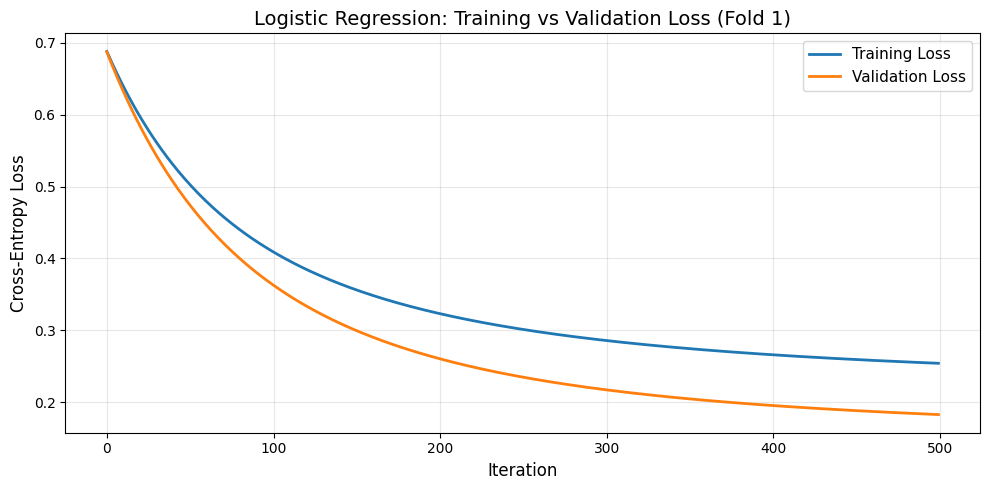

In [13]:
# TODO: Plot training and validation loss curves (1 points)

plt.figure(figsize=(10, 5))
# TODO: Create the plot  (1 points)
plt.plot(plot_train_losses, label='Training Loss', linewidth=2)
plt.plot(plot_val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title(f'Logistic Regression: Training vs Validation Loss (Fold {plot_fold})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Question 2:** Why do we use the sigmoid function in Logistic Regression? (4 points, 4-5 sentences)

**[YOUR ANSWER HERE]**

---

# Task 3: Decision Tree (30 points)

Implement a Decision Tree classifier using information gain (entropy) for multi-class classification of all three Iris species.

**Hyperparameters to tune:**
- Maximum depth: `[3, 5, 10]`
- Minimum samples to split: `[2, 5, 10]`

## 3.1: Implement DecisionTree Class (20 points)

In [ ]:
class DecisionTreeNode:
    """A node in the decision tree."""

    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        """
        Initialise a tree node.

        For internal nodes:
            feature_idx: Index of feature to split on
            threshold: Threshold value for the split
            left: Left child node (feature <= threshold)
            right: Right child node (feature > threshold)

        For leaf nodes:
            value: Predicted class label
        """
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        """Check if this node is a leaf."""
        return self.value is not None


class DecisionTree:
    """
    Decision Tree classifier using information gain (entropy).

    Attributes:
        max_depth: Maximum depth of the tree
        min_samples_split: Minimum samples required to split a node
        min_samples_leaf: Minimum samples required in a leaf node
        root: Root node of the tree
    """

    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        """
        Initialise the Decision Tree.

        Args:
            max_depth: Maximum depth of the tree
            min_samples_split: Minimum samples required to split
            min_samples_leaf: Minimum samples required in a leaf (fixed 1)
        """
        # TODO: Store hyperparameters (1 points)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def _entropy(self, y):
        """
        Compute entropy of a label array.

        Entropy = -sum(p * log2(p)) for each class

        Hint: Handle the case where p=0 (0 * log(0) = 0)
        """
        if len(y) == 0:
            return 0

        # Count occurrences of each class
        counts = np.bincount(y)
        # Calculate probabilities
        probabilities = counts[counts > 0] / len(y)

        # Compute entropy: -sum(p * log2(p))
        entropy = -np.sum(probabilities * np.log2(probabilities))

        return entropy

    def _information_gain(self, y, y_left, y_right):
        """
        Compute information gain from a split.

        IG = entropy(parent) - weighted_avg(entropy(children))
        """
        # TODO: Implement information gain (2 points)
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)

        # Parent entropy
        parent_entropy = self._entropy(y)

        # Weighted average of children entropies
        if n_left == 0 or n_right == 0:
            return 0

        weighted_child_entropy = (n_left / n) * self._entropy(y_left) + \
                                  (n_right / n) * self._entropy(y_right)

        # Information gain
        info_gain = parent_entropy - weighted_child_entropy

        return info_gain

    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split on.

        Returns:
            best_feature_idx, best_threshold, best_gain
            Returns (None, None, 0) if no valid split found
        """
        # TODO: Implement best split search (5 points)
        # Steps:
        # 1. For each feature:
        #    a. Get unique values as potential thresholds
        #    b. For each threshold:
        #       - Split data into left (<=) and right (>)
        #       - Check min_samples_leaf constraint
        #       - Compute information gain
        #       - Track best split
        # 2. Return best feature, threshold, and gain
        # TODO: Implement best split search (5 points)
        best_gain = 0
        best_feature_idx = None
        best_threshold = None

        n_features = X.shape[1]

        # 1. For each feature:
        for feature_idx in range(n_features):
            # a. Get unique values as potential thresholds
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)

            # b. For each threshold:
            for threshold in thresholds:
                # Split data into left (<=) and right (>)
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold

                y_left = y[left_mask]
                y_right = y[right_mask]

                # Check min_samples_leaf constraint
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                # Compute information gain
                gain = self._information_gain(y, y_left, y_right)

                # Track best split
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        # 2. Return best feature, threshold, and gain
        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.

        Args:
            X: Features
            y: Labels
            depth: Current depth

        Returns:
            DecisionTreeNode
        """
        # TODO: Implement recursive tree building (6 points)
        # Steps:
        # 1. Check stopping conditions:
        #    - max_depth reached
        #    - all samples same class
        #    - n_samples < min_samples_split
        #    If stopping, return leaf with majority class
        #
        # 2. Find best split
        #    If no valid split, return leaf
        #
        # 3. Split data and recursively build children
        #
        # 4. Return internal node with split info
        # TODO: Implement recursive tree building (6 points)
        n_samples = len(y)
        n_classes = len(np.unique(y))

        # 1. Check stopping conditions:
        # - max_depth reached
        # - all samples same class
        # - n_samples < min_samples_split
        if (depth >= self.max_depth or
            n_classes == 1 or
            n_samples < self.min_samples_split):
            # Return leaf with majority class
            leaf_value = np.argmax(np.bincount(y))
            return DecisionTreeNode(value=leaf_value)

        # 2. Find best split
        feature_idx, threshold, gain = self._best_split(X, y)

        # If no valid split, return leaf
        if feature_idx is None:
            leaf_value = np.argmax(np.bincount(y))
            return DecisionTreeNode(value=leaf_value)

        # 3. Split data and recursively build children
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold

        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        # 4. Return internal node with split info
        return DecisionTreeNode(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_child,
            right=right_child
        )

    def fit(self, X, y):
        """
        Train the decision tree.

        Args:
            X: Training features
            y: Training labels

        Returns:
            self
        """
        # TODO: Build the tree (2 points)
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _predict_sample(self, x, node):
        """
        Predict class for a single sample by traversing the tree.
        """
        # TODO: Traverse tree to make prediction (1 points)
        # If leaf node, return the value
        if node.is_leaf():
            return node.value

        # Otherwise, traverse left or right based on feature value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """
        Make predictions for all samples.

        Args:
            X: Features

        Returns:
            Array of predictions
        """
        # TODO: Predict for each sample (1 points)
        predictions = np.array([self._predict_sample(x, self.root) for x in X])
        return predictions

## 3.2: 5-Fold Cross-Validation for Decision Tree (10 points)

**Steps:**
1. Prepare data: Multi-class classification (all 3 classes)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot validation accuracy for different max_depth values

In [ ]:
# Prepare data for Decision Tree
# Multi-class classification: all 3 classes
X_tree = X_full.copy()
y_tree = y_full.copy()

print(f"Decision Tree Data:")
print(f"  X shape: {X_tree.shape}")
print(f"  y shape: {y_tree.shape}")
print(f"  Classes: {list(iris.target_names)}")

# Hyperparameter grid
max_depths = [3, 5, 10]
min_samples_leafs = [1, 2, 4]

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting (track validation accuracy vs max_depth from one fold)
depth_val_accuracies = {d: [] for d in max_depths}

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("DECISION TREE: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_tree), 1):
    print(f"\n--- Fold {fold_num} ---")

    # Split data
    X_train_full, X_test = X_tree[train_idx], X_tree[test_idx]
    y_train_full, y_test = y_tree[train_idx], y_tree[test_idx]

    # TODO: Further split train into train_inner and validation (80%-20%)
    split_idx = int(0.8 * len(X_train_full))
    X_train_inner = X_train_full[:split_idx]
    y_train_inner = y_train_full[:split_idx]
    X_val = X_train_full[split_idx:]
    y_val = y_train_full[split_idx:]
    # TODO: Grid search over hyperparameters (5 points)
    # For each combination of (max_depth, min_samples_split, min_samples_leaf):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set
    #   3. Track best parameters
    #   4. For plotting: track average val accuracy for each max_depth
    best_val_accuracy = 0
    best_depth = None
    best_min_split = None

    # Track accuracies for each max_depth for plotting
    depth_accuracies_fold = {d: [] for d in max_depths}

    for max_depth in max_depths:
        for min_split in min_samples_splits:
            # Train model on train_inner
            model = DecisionTree(max_depth=max_depth, min_samples_split=min_split, min_samples_leaf=1)
            model.fit(X_train_inner, y_train_inner)

            # Evaluate on validation set
            y_val_pred = model.predict(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)

            # Track accuracies for this max_depth
            depth_accuracies_fold[max_depth].append(val_accuracy)

            # Track best parameters
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_depth = max_depth
                best_min_split = min_split

    # Store average validation accuracy for each depth (for plotting)
    for depth in max_depths:
        avg_acc = np.mean(depth_accuracies_fold[depth])
        depth_val_accuracies[depth].append(avg_acc)

    print(f"  Best params: max_depth={best_depth}, min_samples_split={best_min_split}, val_acc={best_val_accuracy:.4f}")
    best_params_per_fold.append({'max_depth': best_depth, 'min_samples_split': best_min_split})


    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = DecisionTree(max_depth=best_depth, min_samples_split=best_min_split, min_samples_leaf=1)
    final_model.fit(X_train_full, y_train_full)
    # TODO: Evaluate on test set and store results (1 points)
    # Store: accuracy, precision (macro), recall (macro), f1 (macro)

    y_test_pred = final_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    accuracy_scores.append(test_accuracy)
    precision_scores_list.append(test_precision)
    recall_scores_list.append(test_recall)
    f1_scores_list.append(test_f1)

    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test Precision (macro): {test_precision:.4f}")
    print(f"  Test Recall (macro): {test_recall:.4f}")
    print(f"  Test F1 (macro): {test_f1:.4f}")

# TODO: Print final results with mean, std, and 95% CI for all metrics (1 points)
print("\n" + "="*60)
print("DECISION TREE: FINAL RESULTS")
print("="*60)

print_results("Test Accuracy", accuracy_scores)
print_results("Test Precision (macro)", precision_scores_list)
print_results("Test Recall (macro)", recall_scores_list)
print_results("Test F1 (macro)", f1_scores_list)

print(f"\nBest hyperparameters per fold:")
for i, params in enumerate(best_params_per_fold, 1):
    print(f"  Fold {i}: max_depth={params['max_depth']}, min_samples_split={params['min_samples_split']}")



In [ ]:
# TODO: Plot validation accuracy vs max_depth (1 points)

plt.figure(figsize=(10, 5))
# TODO: Create the plot (1 points)

# Calculate mean and std for each max_depth across all folds
mean_accuracies = [np.mean(depth_val_accuracies[d]) for d in max_depths]
std_accuracies = [np.std(depth_val_accuracies[d]) for d in max_depths]

# Plot with error bars
plt.plot(max_depths, mean_accuracies, marker='o', linewidth=2, markersize=8, label='Mean Validation Accuracy')
plt.fill_between(max_depths,
                 np.array(mean_accuracies) - np.array(std_accuracies),
                 np.array(mean_accuracies) + np.array(std_accuracies),
                 alpha=0.2, label='±1 Std Dev')

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Decision Tree: Validation Accuracy vs Max Depth', fontsize=14)
plt.xticks(max_depths)
plt.ylim([0.8, 1.0])  # Adjust based on your data
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Question 3:** What are the risks of having a tree that is too shallow or too deep? (4 points, 4-5 sentences)

**[YOUR ANSWER HERE]**

---

# Convert Your Colab Notebook to PDF

### Step 1: Download Your Notebook
- Go to **File → Download → Download .ipynb**
- Save the file to your computer

### Step 2: Upload to Colab
- Click the **📁 folder icon** on the left sidebar
- Click the **upload button**
- Select your downloaded .ipynb file
- Wait for the upload to complete

### Step 3: Run the Code Below
- **Uncomment the cell below** and run the cell
- This will take about 1-2 minutes to install required packages

### Step 4: Enter Notebook Name
- When prompted, type your notebook name (e.g., `gs_000000_project.ipynb`)
- Press Enter

### The PDF will automatically download to your computer

In [ ]:
# # Install required packages (this takes about 30 seconds)
# print("Installing PDF converter... please wait...")
# !apt-get update -qq
# !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null 2>&1
# !pip install -q nbconvert

# print("\n" + "="*50)
# print("COLAB NOTEBOOK TO PDF CONVERTER")
# print("="*50)
# print("\nSTEP 1: Download your notebook")
# print("- Go to File → Download → Download .ipynb")
# print("- Save it to your computer")
# print("\nSTEP 2: Upload it here")
# print("- Click the folder icon on the left (📁)")
# print("- Click the upload button and select your .ipynb file")
# print("- Wait for upload to complete")
# print("\nSTEP 3: Enter the filename below")
# print("="*50)

# # Get notebook name from user
# notebook_name = input("\nEnter your notebook name: ")

# # Add .ipynb if missing
# if not notebook_name.endswith('.ipynb'):
#     notebook_name += '.ipynb'

# import os
# notebook_path = f'/content/{notebook_name}'

# # Check if file exists
# if not os.path.exists(notebook_path):
#     print(f"\n⚠ Error: '{notebook_name}' not found in /content/")
#     print("\nMake sure you uploaded the file using the folder icon (📁) on the left!")
# else:
#     print(f"\n✔ Found {notebook_name}")
#     print("Converting to PDF... this may take 1-2 minutes...\n")

#     # Convert the notebook to PDF
#     !jupyter nbconvert --to pdf "{notebook_path}"

#     # Download the PDF
#     from google.colab import files
#     pdf_name = notebook_name.replace('.ipynb', '.pdf')
#     pdf_path = f'/content/{pdf_name}'

#     if os.path.exists(pdf_path):
#         print("✔ SUCCESS! Downloading your PDF now...")
#         files.download(pdf_path)
#         print("\n✔ Done! Check your downloads folder.")
#     else:
#         print("⚠ Error: Could not create PDF")